# SQL TRANSACTIONS

Transaktionen stellen sicher, dass **_alle Anweisungen innerhalb einer Transaktion entweder erfolgreich sind oder nicht_**. Eine teilweise Ausführung ist nicht zulässig. Transaktionen kapseln Vorgänge, die logisch zusammen auftreten müssen, z. B. mehrere Einträge in verknüpfte Tabellen, die Teil eines einzelnen Vorgangs sind.  

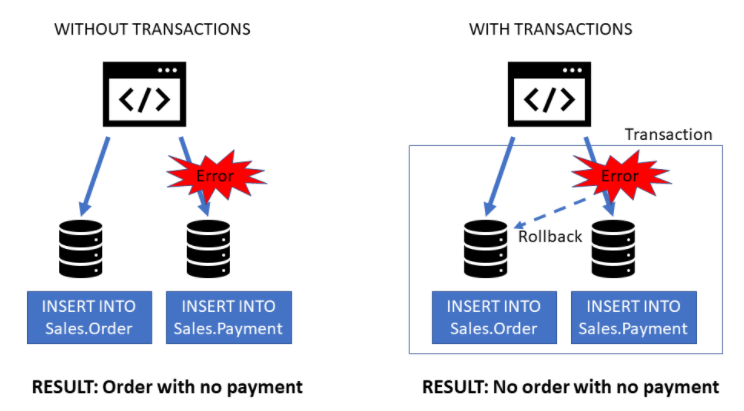  

**<u>Hinweis:</u>** Beachten Sie, dass sich dies auf schwerwiegende Fehler bezieht, z. B. Hardware- oder Netzwerkfehler. Fehler in SQL-Anweisungen würden nur dazu führen, dass für die Transaktion unter bestimmten Umständen ein Rollback ausgeführt wird, und es ist wichtig, die nachfolgenden Einheiten in diesem Modul zu überprüfen, um die Auswirkungen der Verwendung von Transaktionen vollständig zu verstehen.

# Explizite Transaktionen

Die Schlüsselwörter BEGIN TRANSACTION und entweder COMMIT oder ROLLBACK starten und beenden jeden Batch von Anweisungen. Dadurch können Sie angeben, für welche Anweisungen ein Commit oder ein Rollback ausgeführt werden muss.

Anfang - BEGIN TRANSACTION / BEGIN TRAN  
wenn erfolgreich - COMMIT TRANSACTION / COMMIT TRAN  
wenn Fehler - ROLLBACK TRANSACTION / ROLLBACK TRAN

## Transaction vs. Batches

Die Batches werden ausgeführt, auch wenn einer dazwischen einen Fehler wirft

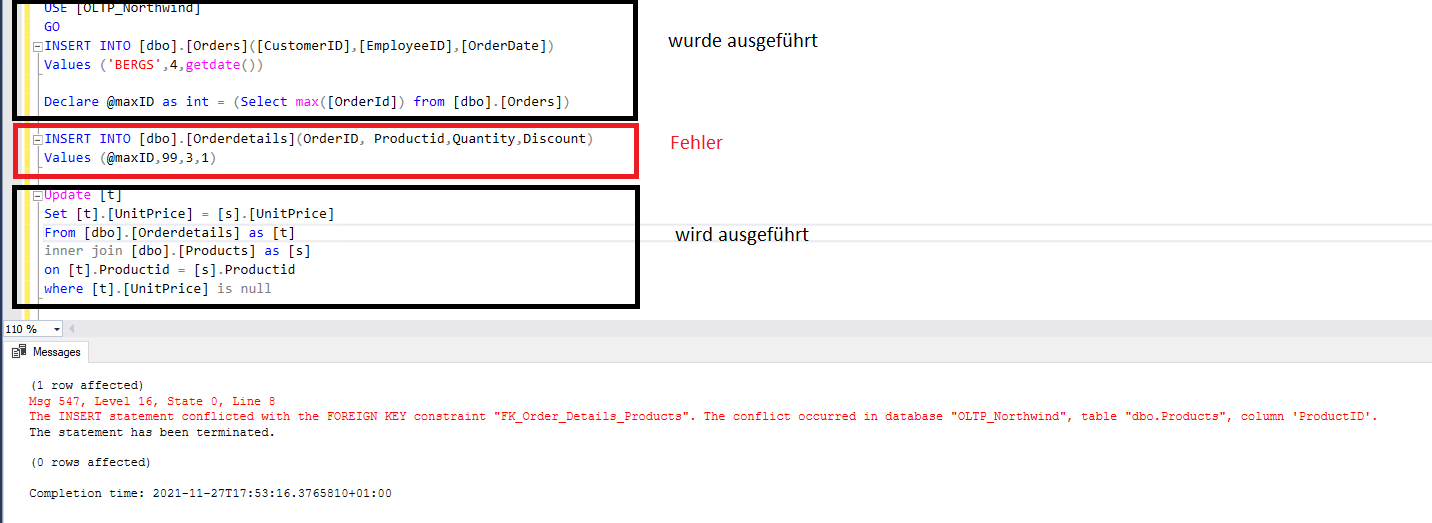

In [1]:
USE [OLTP_Northwind]
GO
INSERT INTO [dbo].[Orders]([CustomerID],[EmployeeID],[OrderDate])
Values ('BERGS',4,getdate())

Declare @maxID as int = (Select max([OrderId]) from [dbo].[Orders])

INSERT INTO [dbo].[Orderdetails](OrderID, Productid,Quantity,Discount)
Values (@maxID,99,3,1)

Update [t]
Set [t].[UnitPrice] = [s].[UnitPrice]
From [dbo].[Orderdetails] as [t]
inner join [dbo].[Products] as [s]
on [t].Productid = [s].Productid
where [t].[UnitPrice] is null

Commands completed successfully.

(1 row affected)

: Msg 547, Level 16, State 0, Line 8
The INSERT statement conflicted with the FOREIGN KEY constraint "FK_Order_Details_Products". The conflict occurred in database "OLTP_Northwind", table "dbo.Products", column 'ProductID'.

The statement has been terminated.

(0 rows affected)

Total execution time: 00:00:00.310

In [2]:
USE [OLTP_Northwind]
GO
-- Bereinigung
Delete [dbo].[Orderdetails]
Where OrderID in (Select Orderid from [dbo].[Orders] Where Cast([OrderDate] as date) = Cast(getdate() as date))

Delete [dbo].[Orders]
Where Cast([OrderDate] as date) = Cast(getdate() as date)

Commands completed successfully.

(0 rows affected)

(1 row affected)

Total execution time: 00:00:00.017

## Transaction vs TRY-CATCH

Nachdem der Fehler aufgetreten ist, greift der CATCH Block

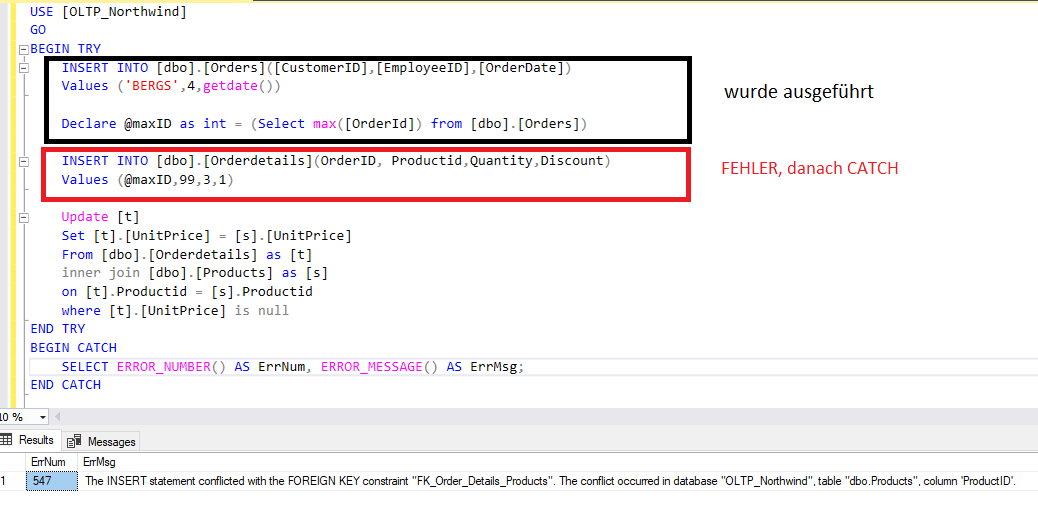

In [3]:
USE [OLTP_Northwind]
GO
BEGIN TRY
	INSERT INTO [dbo].[Orders]([CustomerID],[EmployeeID],[OrderDate])
	Values ('BERGS',4,getdate())

	Declare @maxID as int = (Select max([OrderId]) from [dbo].[Orders])

	INSERT INTO [dbo].[Orderdetails](OrderID, Productid,Quantity,Discount)
	Values (@maxID,99,3,1)

	Update [t]
	Set [t].[UnitPrice] = [s].[UnitPrice]
	From [dbo].[Orderdetails] as [t]
	inner join [dbo].[Products] as [s]
	on [t].Productid = [s].Productid
	where [t].[UnitPrice] is null
END TRY
BEGIN CATCH
	SELECT ERROR_NUMBER() AS ErrNum, ERROR_MESSAGE() AS ErrMsg;
END CATCH

Commands completed successfully.

(1 row affected)

(0 rows affected)

(1 row affected)

Total execution time: 00:00:00.046

ErrNum,ErrMsg
547,"The INSERT statement conflicted with the FOREIGN KEY constraint ""FK_Order_Details_Products"". The conflict occurred in database ""OLTP_Northwind"", table ""dbo.Products"", column 'ProductID'."


In [ ]:
USE [OLTP_Northwind]
GO
-- Bereinigung
Delete [dbo].[Orderdetails]
Where OrderID in (Select Orderid from [dbo].[Orders] Where Cast([OrderDate] as date) = Cast(getdate() as date))

Delete [dbo].[Orders]
Where Cast([OrderDate] as date) = Cast(getdate() as date)

## optimal TRY-CATCH WITH TRANSACTIONS

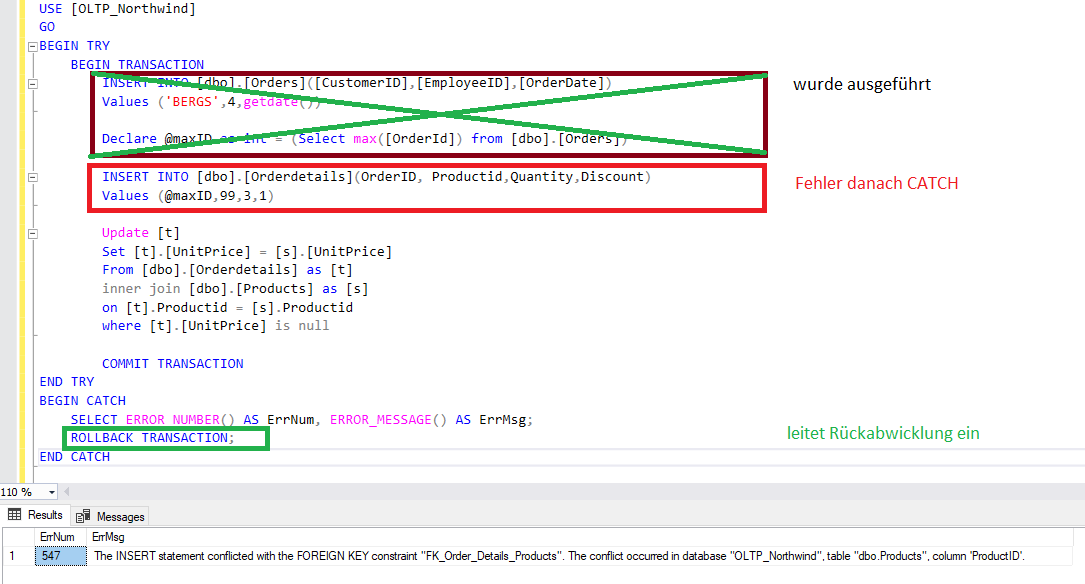

In [4]:
USE [OLTP_Northwind]
GO
BEGIN TRY
	BEGIN TRANSACTION t1
		INSERT INTO [dbo].[Orders]([CustomerID],[EmployeeID],[OrderDate])
		Values ('BERGS',4,getdate())

		Declare @maxID as int = (Select max([OrderId]) from [dbo].[Orders])

		INSERT INTO [dbo].[Orderdetails](OrderID, Productid,Quantity,Discount)
		Values (@maxID,99,3,1)

		Update [t]
		Set [t].[UnitPrice] = [s].[UnitPrice]
		From [dbo].[Orderdetails] as [t]
		inner join [dbo].[Products] as [s]
		on [t].Productid = [s].Productid
		where [t].[UnitPrice] is null
	
	COMMIT TRANSACTION t1
END TRY
BEGIN CATCH
	SELECT ERROR_NUMBER() AS ErrNum, ERROR_MESSAGE() AS ErrMsg;
	ROLLBACK TRANSACTION t1
END CATCH

Commands completed successfully.

(1 row affected)

(0 rows affected)

(1 row affected)

Total execution time: 00:00:00.012

ErrNum,ErrMsg
547,"The INSERT statement conflicted with the FOREIGN KEY constraint ""FK_Order_Details_Products"". The conflict occurred in database ""OLTP_Northwind"", table ""dbo.Products"", column 'ProductID'."


## GESCHACHTELTE TRANSACTIONS

Transaktionen können geschachtelt werden. In diesem Fall wird für die inneren Transaktionen ein Rollback ausgeführt, wenn für die äußere Transaktion ein Rollback ausgeführt wird.

## XACT\_ABORT

Standardeinstellung: XACT\_ABORT = OFF - in diesem Fall wird in Abhängigkeit der Severity (Schwere des Fehlers) die ganze Transaktion abgebrochen, oder weiter fortgeführt.

**<u>XACT\_ABORT = off</u>**

Fehler Level 14 =\> Statement fails; kein Rollback  
Fehler Level 16 =\> Statement fails; Rollback

In [5]:
-- Vorbereitung
USE AdventureWorks2017
GO
DROP TABLE if exists tab
CREATE TABLE Tab (x INT NOT NULL PRIMARY KEY)
 
INSERT INTO Tab VALUES (1)
INSERT INTO Tab VALUES (2)
INSERT INTO Tab VALUES (3)
GO

Commands completed successfully.

(1 row affected)

(1 row affected)

(1 row affected)

Total execution time: 00:00:00.020

In [ ]:
SET XACT_ABORT OFF; -- By default it is OFF
 
BEGIN TRANSACTION
    INSERT INTO Tab VALUES (4)
    INSERT INTO Tab VALUES (4) -- Statement fails but transaction is committed.
    INSERT INTO Tab VALUES (5)
COMMIT TRANSACTION
GO
Select * from tab

In [ ]:
SET XACT_ABORT OFF; -- By default it is OFF
 
BEGIN TRANSACTION
    INSERT INTO Tab VALUES (4)
    INSERT INTO Tab VALUES ('Test')  --Statment fails and is RolledBack
    INSERT INTO Tab VALUES (5)
COMMIT TRANSACTION
GO
Select * from tab

In [ ]:
-- Bereinigung
DROP TABLE if exists tab

**<u>XACT\_ABORT = ON</u>**

Fehler Level 14 =\> Statement fails; Rollback  
Fehler Level 16 =\> Statement fails; Rollback

In [ ]:
-- Vorbereitung
USE AdventureWorks2017
GO
DROP TABLE if exists tab
CREATE TABLE Tab (x INT NOT NULL PRIMARY KEY)
 
INSERT INTO Tab VALUES (1)
INSERT INTO Tab VALUES (2)
INSERT INTO Tab VALUES (3)
GO

In [ ]:
SET XACT_ABORT OFF; -- By default it is OFF
 
BEGIN TRANSACTION
    INSERT INTO Tab VALUES (4)
    INSERT INTO Tab VALUES ('Test')  --Statment fails and is RolledBack
    INSERT INTO Tab VALUES (5)
COMMIT TRANSACTION
GO
Select * from tab

## XACT\_STATE

Um einen Rollback einer aktiven Transaktion zu vermeiden, verwenden Sie die XACT\_STATE Funktion. XACT\_STATE gibt die folgenden Werte zurück:

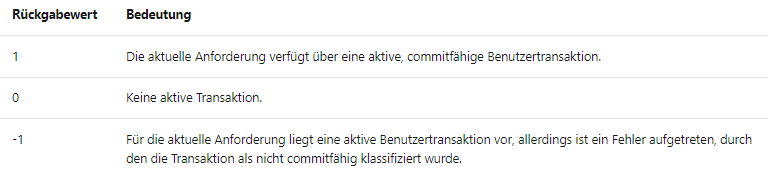

optimales Fehlerhandling:

In [ ]:
-- Vorbereitung
USE OLTP_Northwind
GO
DROP TABLE IF EXISTS DB_Errors
GO
CREATE TABLE DB_Errors
         (ErrorID        INT IDENTITY(1, 1),
          UserName       VARCHAR(100),
          ErrorNumber    INT,
          ErrorState     INT,
          ErrorSeverity  INT,
          ErrorLine      INT,
          ErrorProcedure VARCHAR(MAX),
          ErrorMessage   VARCHAR(MAX),
          ErrorDateTime  DATETIME)
GO

In [ ]:
Select * from [dbo].[Categories]

In [ ]:
CREATE PROCEDURE dbo.usp_AddCategory 
	@CategoryName nvarchar(15) = null,
	@Description ntext = null,
	@CategoryID int output
AS
  BEGIN TRY
    BEGIN TRANSACTION
	--- prüfen, ob enahtalten
	Declare @C as int = (Select Count(*) from [dbo].[Categories]
		where [CategoryName] = @CategoryName)
	if (@C = 0 )
	Begin 
		--- Einfügen
		INSERT INTO [dbo].[Categories]([CategoryName],[Description])
		Values(@CategoryName,@Description)
    END
	Set @CategoryID = (Select Top 1 [CategoryID] from [dbo].[Categories]
		where [CategoryName] = @CategoryName)
	if (@C <> 0 )
    BEGIN
        Update [dbo].[Categories]
        Set [Description] = @Description
        where [CategoryID] = @CategoryID
    END
    COMMIT TRANSACTION
  END TRY
  BEGIN CATCH
    INSERT INTO dbo.DB_Errors
    VALUES
  (SUSER_SNAME(),
   ERROR_NUMBER(),
   ERROR_STATE(),
   ERROR_SEVERITY(),
   ERROR_LINE(),
   ERROR_PROCEDURE(),
   ERROR_MESSAGE(),
   GETDATE());
 
-- Transaction uncommittable
    IF (XACT_STATE()) = -1
      ROLLBACK TRANSACTION
 
-- Transaction committable
    IF (XACT_STATE()) = 1
      COMMIT TRANSACTION
  END CATCH
GO

In [ ]:
DECLARE @CatID as int 
----
EXECUTE dbo.usp_AddCategory @CategoryName = 'Beverages', @Description = 'Soft drinks, coffees, teas, beers, and ales', @CategoryID = @CatID output
print @CatID
Select * from [dbo].[Categories]
----   
EXECUTE dbo.usp_AddCategory @CategoryName = 'Beverages', @Description = 'new Text', @CategoryID = @CatID output
print @CatID
Select * from [dbo].[Categories]
----
EXECUTE dbo.usp_AddCategory @CategoryName = 'Beverages2', @Description = 'Soft drinks, coffees, teas, beers, and ales', @CategoryID = @CatID output
print @CatID
Select * from [dbo].[Categories]
---- wirft Fehler => LOG
EXECUTE dbo.usp_AddCategory @CategoryName = NULL, @Description = 'Soft drinks, coffees, teas, beers, and ales', @CategoryID = @CatID output
print @CatID
Select * from [dbo].[Categories]

In [ ]:
Select * from dbo.DB_Errors

In [ ]:
-- Aufräumen
Delete [dbo].[Categories] where [CategoryName] = 'Beverages2'
DECLARE @CatID as int 
EXECUTE dbo.usp_AddCategory @CategoryName = 'Beverages', @Description = 'Soft drinks, coffees, teas, beers, and ales', @CategoryID = @CatID output

# Implizite Transaktionen

Eine Transaktion wird gestartet, wenn die vorherige Transaktion abgeschlossen wurde. Jede Transaktion wird explizit mit einer COMMIT- oder ROLLBACK-Anweisung abgeschlossen.

# SQL-Parallelität

Bei Parallelität werden Daten mit Sperren und Blockierungen für viele Benutzer konsistent gehalten, die gleichzeitig Daten aktualisieren und lesen. Die Arbeitseinheit, bei der Parallelität berücksichtigt wird, ist eine Transaktion. Eine Transaktion, die einige Daten aktualisiert, kann verhindern, dass andere Transaktionen diese Daten aktualisieren oder lesen. Ebenso kann eine Transaktion, die einige Daten liest, andere Transaktionen daran hindern, diese Daten zu aktualisieren. Aus diesem Grund ist es wichtig, unnötig lange Transaktionen zu vermeiden, oder Transaktionen, die übermäßig große Datenmengen betreffen.  

  

- Optimistische Nebenläufigkeit
- Pessimistische Parallelität
- Momentaufnahmenisolation

siehe eigene Datei